In [32]:
pip install Pillow

In [33]:
!sudo apt install easyocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package easyocr


In [34]:
pip install img2table

In [35]:
pip install easyocr openai matplotlib python-dotenv

In [36]:
pip install img2table[easyocr]

In [37]:
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import cv2 as cv
from numpy import asarray
import pandas as pd
from PIL import Image as PILImage
import easyocr


In [38]:
from img2table.ocr import EasyOCR
from img2table.document import Image

In [39]:
def scaleimg(pic):
    img = cv.imread(pic, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"
    th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
    cv.THRESH_BINARY,31,36)
    morph_kernel = np.ones([1,1])
    inverted_image = cv.bitwise_not(th3)
    image = inverted_image
    erode_img = cv.erode(image, kernel= morph_kernel, iterations=5)
    #plt.figure(figsize=(10,15))
    #plt.imshow(erode_img,'gray')
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    hor = np.array([[1,1,1,1,1,1]])
    vertical_lines_eroded_image = cv.erode(erode_img, hor, iterations=1)
    vertical_lines_eroded_image = cv.dilate(vertical_lines_eroded_image, hor, iterations=1)

    ver = np.array([[1],
                [1],
                [1],
                [1],
                [1],
                [1],
                [1]])
    horizontal_lines_eroded_image = cv.erode(erode_img, ver, iterations=1)
    horizontal_lines_eroded_image = cv.dilate(horizontal_lines_eroded_image, ver, iterations=1)

    combined_image = cv.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
    combined_image_dilated = cv.dilate(combined_image, kernel, iterations=1)

    ret, thresh = cv.threshold(combined_image_dilated, 140, 170, 0)
    cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cc = []
    for c in cnts:
        area = cv.contourArea(c)
        if area > 5000:
            # Find distorted bounding rect
            rect = cv.minAreaRect(c)
            corners = cv.boxPoints(rect)
            corners = np.int0(corners)
            cv.fillPoly(mask, [corners], (255,255,255))

            # Draw corner points
            corners = corners.tolist()
            cc.append(corners)
            for i in range(len(cc)):
                xx = []
                yy = []
                if cc[i][0][0] < (img.shape[1]*3/4):
                    for corner in cc[i]:
                        x, y = corner
                        xx.append(x)
                        yy.append(y)
                        cv.circle(image, (x, y), 5, 255, -1)
                else:
                    pass

                img = cv.imread(pic, cv.IMREAD_GRAYSCALE)

                pt_A = [xx[0], yy[0]]
                pt_B = [xx[1], yy[1]]
                pt_C = [xx[2], yy[2]]
                pt_D = [xx[3], yy[3]]

                width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
                width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
                maxWidth = max(int(width_AD), int(width_BC))


                height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
                height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
                maxHeight = max(int(height_AB), int(height_CD))

                input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
                output_pts = np.float32([[0, 0],
                                            [0, maxHeight - 1],
                                            [maxWidth - 1, maxHeight - 1],
                                            [maxWidth - 1, 0]])

                M = cv.getPerspectiveTransform(input_pts,output_pts)
                out = cv.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv.INTER_LINEAR)


                h = cv.flip(out,1)

                #img = Image.fromarray(h)
                #img = img.filter(ImageFilter.SHARPEN)
                if out.shape[0] < out.shape[1]:
                  h = cv.flip(out,1)
                  image = cv.rotate(h, cv.ROTATE_180)
                else:
                  h = cv.flip(out,0)
                  image = cv.rotate(h, cv.ROTATE_90_CLOCKWISE)


            return image

In [40]:
def threshold_image(image):

    image = cv.threshold(image, 140, 255, cv.THRESH_BINARY)[1]
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    image = cv.filter2D(image, -1, kernel)
    return image

In [41]:
def border(image):
    border_size = 100
    white = [255,255,255]
    image= cv.copyMakeBorder(image,border_size,border_size,border_size,border_size,cv.BORDER_CONSTANT,value=white)
    return image

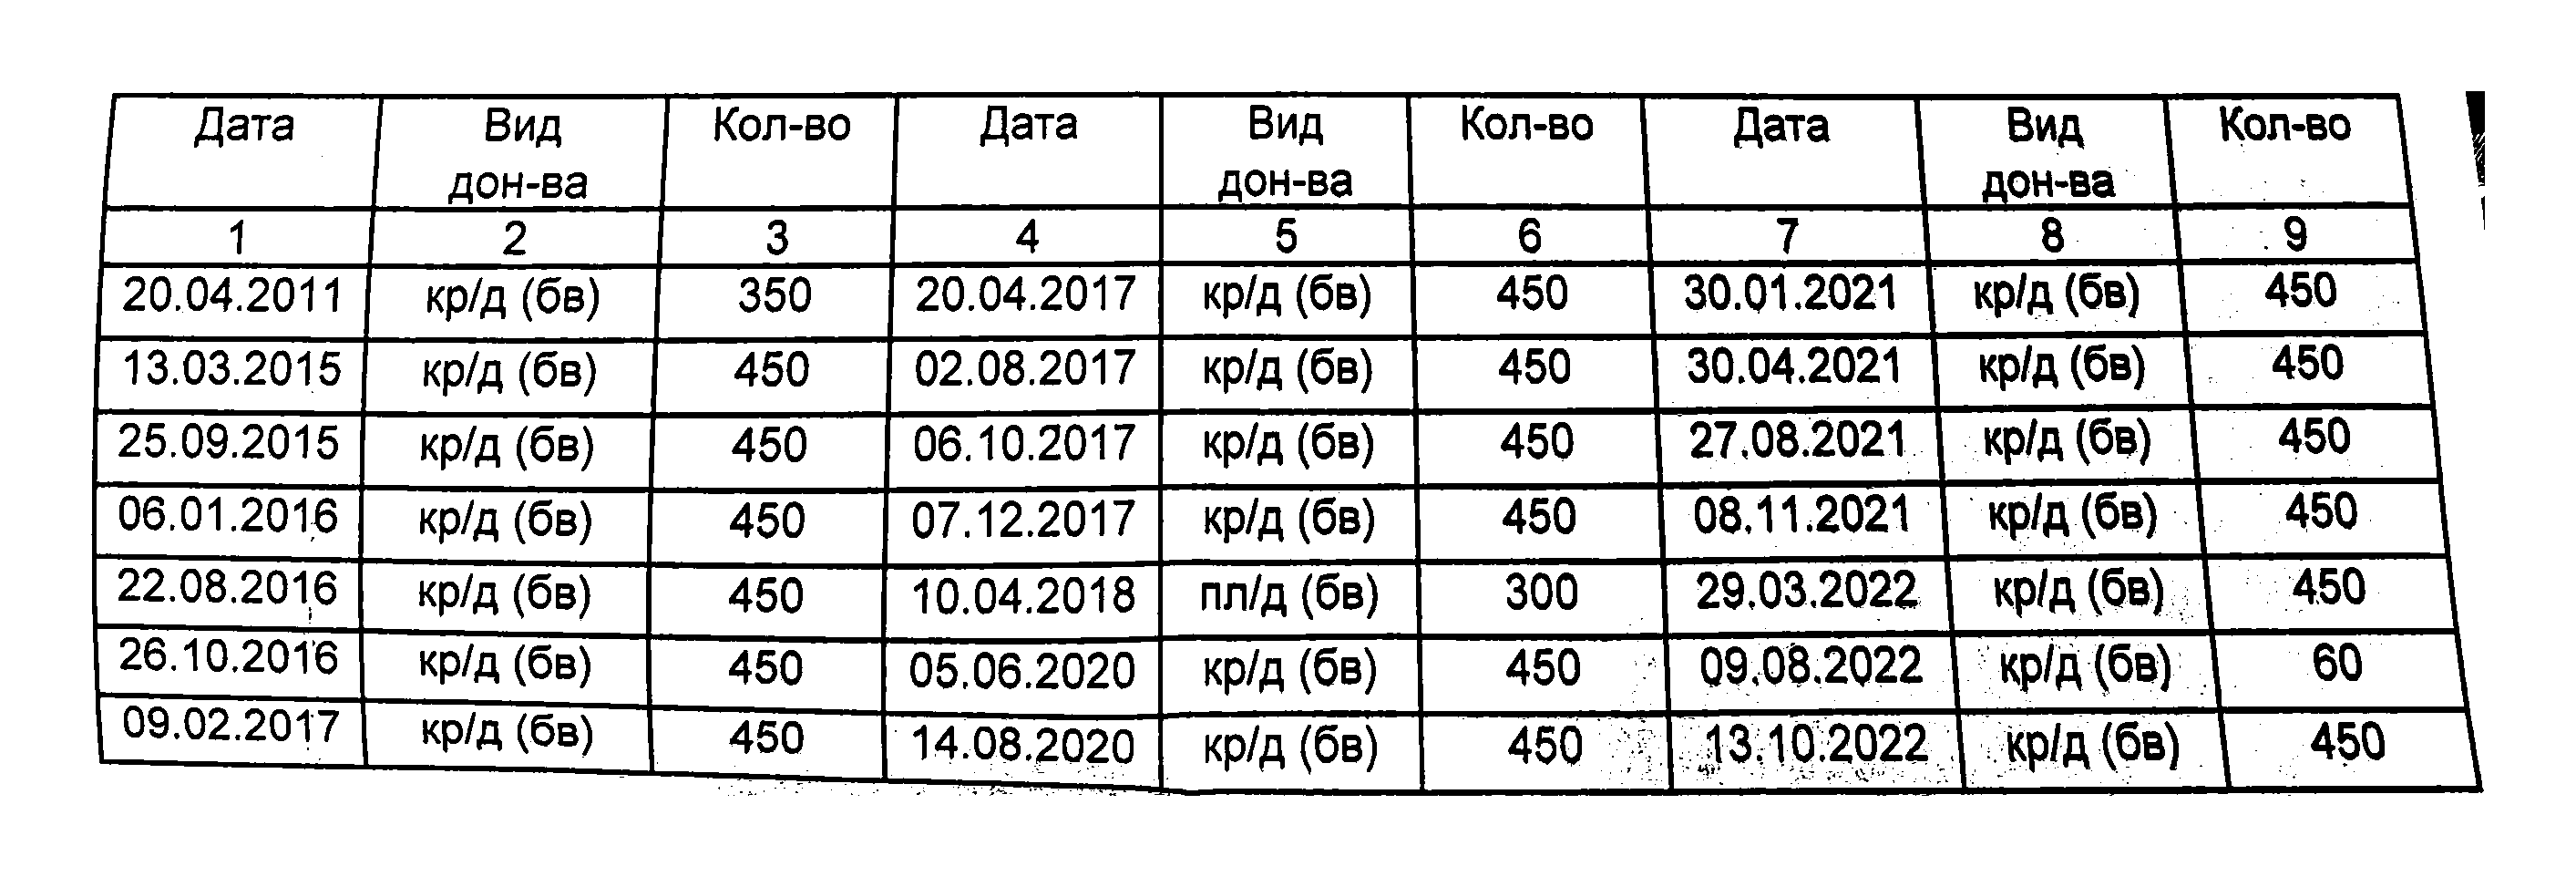

In [42]:
img_233749 = scaleimg('/content/233749 .jpg')
img_233749 = threshold_image(img_233749)
img_233749 = border(img_233749)
cv2_imshow(img_233749)

In [43]:
img = PILImage.fromarray(img_233749)
img.save('233749_new.jpg')

In [44]:
ocr = EasyOCR( lang=["ru"])

In [45]:
doc_233749 = Image('/content/233749_new.jpg')

In [46]:
doc_233749.to_xlsx(dest='table233749.xlsx',
            ocr=ocr,
            implicit_rows=False,
            borderless_tables=False,
            min_confidence=50)